# Debugger and Profiler

In [1]:
# Install dependencies
!pip install smdebug

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6415 sha256=2cfc563d3253a29cece2d61fba0b962fd7b38ffd75da608a071676ae40f4b2e0
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


### Set hyperparameters for our training job

In [2]:
# Set the parameters for the submitting script (this time we're working on a notebook to make it easier)

hyperparameters = {
    "batch_size": 2048,
    "gpu": True,
    "epoch": 2,
    "model": "resnet50",
}

#### Key concepts of Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and provides you alerts, once it has detected inconsistency in training flow.

Concepts
- Tensors: These represent the state of the training network at intermediate points during its execution
- Debug Hook: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
- Rule: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all


In [3]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

# Create debugging and profiling rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()), 
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Instance profiler and debugger configs
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10))

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [10]:
import sagemaker
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

estimator = PyTorch(
    role=role,
    base_job_name="smdebugger-cifar-pytorch-test", #Change for every training job
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="scripts/pytorch_cifar_profiling.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [11]:
# Launch the training job
estimator.fit(wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893


2024-08-15 20:43:09 Starting - Starting the training job
2024-08-15 20:43:09 Pending - Training job waiting for capacity...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2024-08-15 20:44:39 Pending - Preparing the instances for training...
2024-08-15 20:44:59 Downloading - Downloading input data...
2024-08-15 20:45:39 Downloading - Downloading the training image..............................
2024-08-15 20:50:40 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-15 20:50:34,930 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-15 20:50:34,961 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-15 20:50:34,964 sagemaker_pytorch_container.trai

#### Prepare for debugging and profiling analysis

In [12]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893
Region: us-east-1


In [13]:
#
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)

In [15]:
description

{'TrainingJobName': 'smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:118260155862:training-job/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '2048',
  'epoch': '2',
  'gpu': 'true',
  'model': '"resnet50"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893"',
  'sagemaker_program': '"pytorch_cifar_profiling.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch

## Checking Training Performance

A Trial is an object used to interact with and analyze the debugging artifacts generated during a training job. SageMaker Debugger collects data such as tensors, metrics, and other relevant information at different points during the training process. These artifacts are stored in a specific path (e.g., in S3), and the Trial object allows you to access, query, and visualize this data.

In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

# Instance the trial object
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-08-15 21:07:56.090 default:126 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-08-15 21:07:56.108 default:126 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/debug-output


#### Print the names of tracked tensors for both train and evaluation, and the number of datapoints for each tnesor

In [17]:
print(f'Tensor names:\n {trial.tensor_names()}')

[2024-08-15 21:09:08.002 default:126 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-15 21:09:09.018 default:126 INFO trial.py:210] Loaded all steps
Tensor names: ['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.bn3.bias', 'gradient/ResNet_layer1.0.bn3.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.0.conv3.weight', 'gradient/ResNet_layer1.0.downsample.0.weight', 'gradient/ResNet_layer1.0.downsample.1.bias', 'gradient/ResNet_layer1.0.downsample.1.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight', 'gradient/ResNet_layer1.1.bn2.bias', 'gradient/ResNet_

In [18]:
# RENAME THE TENSORS AS OUR MODEL USES CROSSENTROPY LOSS, NOT NLL LOSS
print(f'Datapoints in the training tensor: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))}\n')
print(f'Datapoints in the evaluation tensor: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))}')

Datapoints in the training tensor: 1

Datapoints in the evaluation tensor: 1


### Plot the tracked tensors
Set up functions to plot the output tensors

In [19]:
# Define a function to retrive the desired tensors by name
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

# Def a function to plot the tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


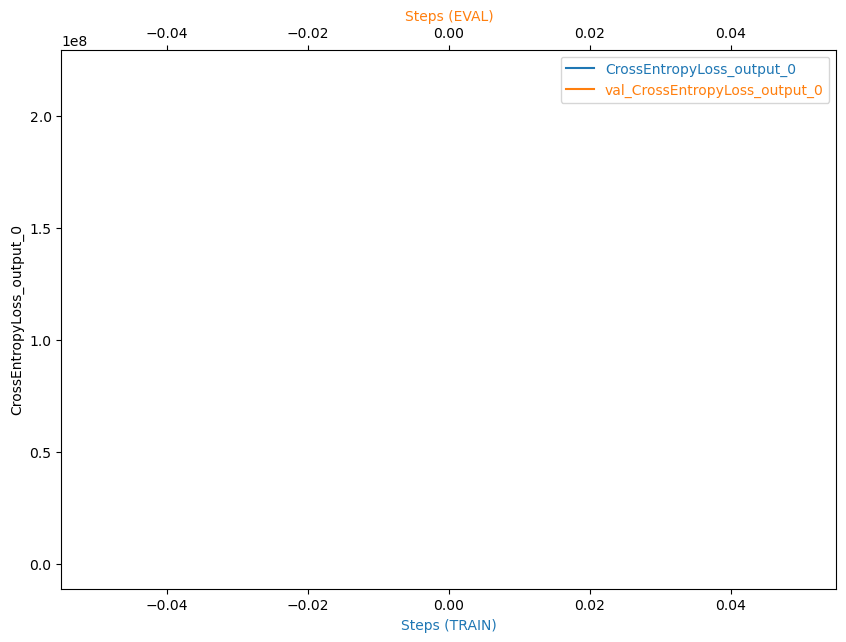

In [22]:
# CANNOT DRAW A LINE FOR 2 EPOCHS, WE NEED MORE DATA
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Check System Utilization

The TrainingJob object tj encapsulates all the information and utilities required to interact with the profiling data collected during the specified training job.

In [24]:
!pip install bokeh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 13.7 MB/s eta 0:00:00


In [25]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-118260155862/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/profiler-output


Profiler data from system is available


In [28]:
type(system_metrics_reader)

smdebug.profiler.system_metrics_reader.S3SystemMetricsReader

In [27]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

# Display system metrics
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"]
)

[2024-08-15 21:20:13.700 default:126 INFO metrics_reader_base.py:134] Getting 22 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


AttributeError: unexpected attribute 'plot_height' to figure, similar attributes are outer_height, height or min_height

## Display the Profiler Report
We will fetch the profiler report from the S3 bucket where it was stored and display it.

In [29]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report at {rule_output_path}")

You will find the profiler report at s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2024-08-15 21:05:52     413297 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-08-15 21:05:52     268884 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-08-15 21:05:47        556 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-08-15 21:05:47      22876 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-08-15 21:05:47       2063 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-08-15 21:05:47        130 smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-08-15 21:05:47        515 smdebugger-cifar-

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-118260155862/smdebugger-cifar-pytorch-test-2024-08-15-20-43-08-893/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-u

In [32]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [33]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")